Installation of Libraries

In [ ]:
!pip install pytesseract

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,738 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
!pip install pdf2image
!pip install python-dateutil

In [ ]:
#Installing popplers
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (148 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122098 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


Step 1: Reading PDF Files

In [ ]:
from pdf2image import convert_from_path

In [ ]:
# Replace 'input_file.pdf' with the path to your PDF file
pdf_file = '/content/C2-08 Demand Note.pdf'
pages = convert_from_path(pdf_file)

In [ ]:
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1475x2200>]

Step 2: Image Preprocessing

In [ ]:
import cv2
import numpy as np

In [ ]:
def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    coords = np.column_stack(np.where(gray > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

Step 3: Running OCR using pytesseract

In [ ]:
import pytesseract

In [ ]:
def extract_text_from_image(image):
    text = pytesseract.image_to_string(image)
    return text

Step 4: Text Extraction

In [ ]:
# Create a list to store extracted text from all pages
extracted_text = []

for page in pages:
    # Step 2: Preprocess the image (deskew)
    preprocessed_image = deskew(np.array(page))

    # Step 3: Extract text using OCR
    text = extract_text_from_image(preprocessed_image)
    extracted_text.append(text)

In [ ]:
print(extracted_text)

['23.01.2023\nTo\nThe Branch Manager,\nState Bank of India,\n\nRACPC-Banswadi,\nBangalore.\n\nSub: Demand letter of Mrs. SHRUTI GURUNATH CHANEKAR alias SHRUTI RUNAKSH BANDEKAR\n\nThis is to inform you that the status of construction related to House/villa no C2-08 admeasuring\nBUA (including carpark area) of 1,650 sft, 250 Sft of common areas, and Carpet area of 1,195 Sft\nsituated at Gudigattanahalli Village, Sarjapura Hobli, Anekal Taluk, Bangalore District.\n\nReference to the above subject matter, we would like to inform you that as the villa Super\nStructure was completed. Hence, we request you to release an amount of Rs.21,12,500/-\n(Rupees Twenty-One Lakhs Twelve Thousand Five Hundred Only) in favor of Whitehill\nProperties LLP-RERA A/c-Royal Tulip # 40359319395.\n\nKindly acknowledge and oblige.\n\nThanking you and assuring our best of services.\nYours faithfully,\n\nFor WHITEHILL PROPERTIES LLP.,\n\n \n\x0c']


Writing to File

In [ ]:
file1 = open("myfile.txt", "w")
file1.writelines(extracted_text)
file1.close()

Step 5: Text Extraction with Additional Preprocessing

In [ ]:
def process_page(page):
    try:
        # Transfer image of pdf_file into array
        page_arr = np.array(page)
        # Transfer into grayscale
        page_arr_gray = cv2.cvtColor(page_arr, cv2.COLOR_BGR2GRAY)
        # Deskew the page
        page_deskew = deskew(page_arr_gray)
        # Cal confidence value
        page_conf = get_conf(page_deskew)
        # Extract string
        d = pytesseract.image_to_data(page_deskew, output_type=pytesseract.Output.DICT)
        d_df = pd.DataFrame.from_dict(d)
        # Get block number
        block_num = int(d_df.loc[d_df['level'] == 2, 'block_num'].max())
        # Drop header and footer by index
        header_index = d_df[d_df['block_num'] == 1].index.values
        footer_index = d_df[d_df['block_num'] == block_num].index.values
        # Combine text in dataframe, excluding header and footer regions
        text = ' '.join(d_df.loc[(d_df['level'] == 5) & (~d_df.index.isin(header_index) & ~d_df.index.isin(footer_index)), 'text'].values)
        return page_conf, text
    except Exception as e:
        # If can't extract then give some notes into df
        if hasattr(e, 'message'):
            return -1, e.message
        else:
            return -1, str(e)

In [ ]:
final_text = process_page(np.array(page))

In [ ]:
final_text

(-1,
 "OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'\n> Invalid number of channels in input image:\n>     'VScn::contains(scn)'\n> where\n>     'scn' is 1\n")

Signature conversion

In [24]:
from pdf2image import convert_from_path
import numpy as np
from matplotlib import pyplot as plt

In [27]:
import imutils

Step 1 : PDF to Image Conversion

In [22]:
pdf_file = '/content/C2-08 Demand Note.pdf'
images = convert_from_path(pdf_file)

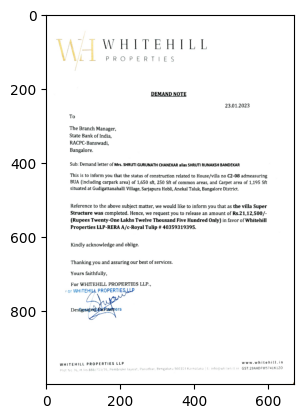

In [28]:
#Visulaize the converted image
for img in images:
    img = np.array(img)
    #resize the image to height of 500 and keep the same aspect ratio
    ratio = img.shape[0]/500.0
    plt.imshow(imutils.resize(img,height=1000))

Step 2 : Contour Detection

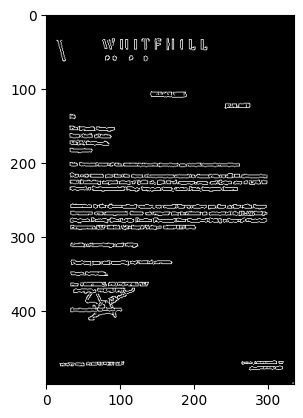

In [33]:
img = np.array(images[-1])
original = img.copy()
ratio = img.shape[0]/500.0
img = imutils.resize(img,height=500)
orig = img.copy()
#converting to grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),0)
plt.imshow(gray,'gray')
edged = cv2.Canny(gray,80,200)
plt.imshow(edged,'gray')

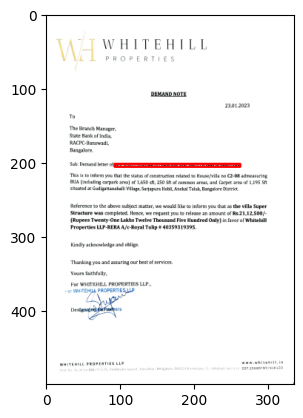

In [30]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key= cv2.contourArea, reverse=True)[:1]
for c in cnts:
 peri = cv2.arcLength(c,True)
 apprx = cv2.approxPolyDP(c, 0.2*peri, True)
 x,y,w,h = cv2.boundingRect(apprx)
 cv2.rectangle(orig,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(orig)